Library import and path define

In [10]:
import os
from datetime import datetime

import joblib
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [11]:
os.chdir("E:/ProjectVirgil/VirgilML")

Load all dataset and split in data and labels

In [12]:
training_data = "data_it\Dataset_Learning_ita.csv"
testing_data = "data_it\Dataset_Testing_ita.csv"
possible_classes = ["OR","MT","GDS","MC","NW","EV","TM","VL","MU","AL"]

dataset_training = shuffle(pd.read_csv(training_data, sep=';', encoding='utf-8'),random_state=42)
dataset_testing =  shuffle(pd.read_csv(testing_data, sep=';', encoding='utf-8'),random_state=42)

train_data = dataset_training["Frasi"]
test_data = dataset_testing["Frasi"]

train_labels = dataset_training["Contesto"]
test_labels = dataset_testing["Contesto"]

Data volume display

OR: 573
MU: 391
AL: 882
MC: 351
NW: 576
EV: 380
MT: 392
VL: 366
GDS: 422
TM: 364


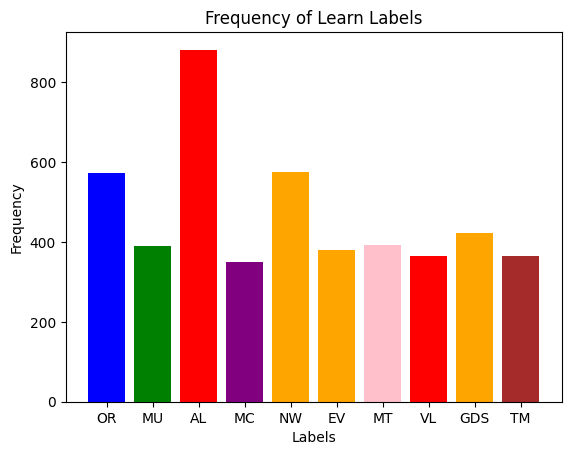

AL: 146
EV: 181
MT: 113
MU: 64
OR: 94
GDS: 91
TM: 79
MC: 78
VL: 30
NW: 30


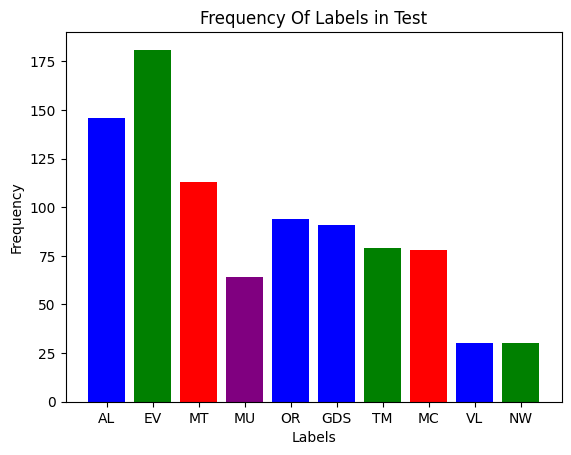

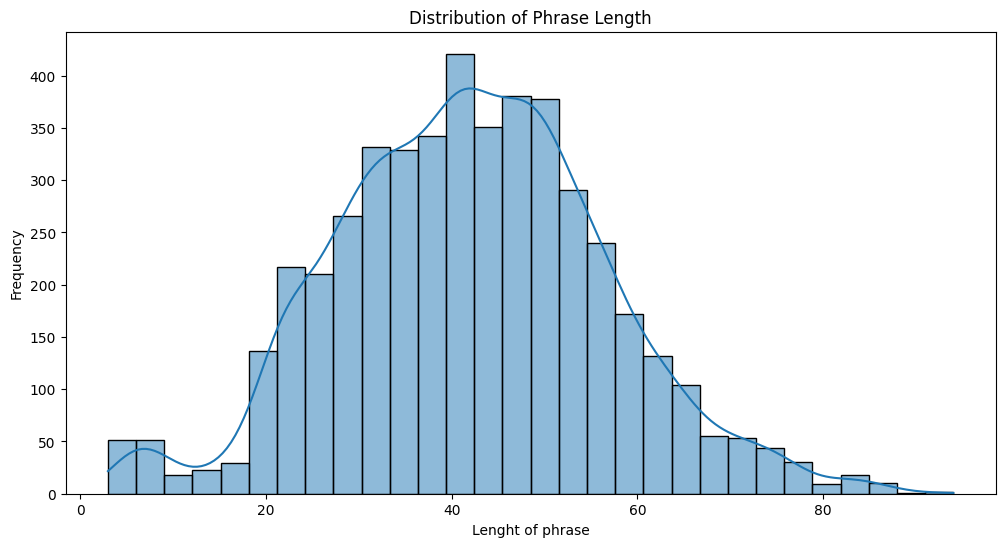

In [13]:

#******************** Training ********************

# Possible classes (labels) present in the data
possible_classes = list(set(train_labels))

# List of color corrispondend at the classes
unique_colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# Calculate the frequency of labels
label_counts = Counter(train_labels)

# Extract unique labels and relative frequency.
unique_labels = list(label_counts.keys())
frequencies = list(label_counts.values())

for index , value in enumerate(unique_labels):
    print(f"{value}: {frequencies[index]}")
# Create a dictionary that maps each label to its corresponding color
label_to_color = {label: color for label, color in zip(unique_labels, unique_colors)}
# Extract the colors corresponding to the labels in your dataset
bar_colors = [label_to_color[label] for label in train_labels]
# Create a bar graph with different colors for each column
plt.bar(unique_labels, frequencies, color=bar_colors)
# Add labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
# Add a title
plt.title('Frequency of Learn Labels')
# Show the bar graph
plt.show()

# Possible classes (labels) present in the data
possible_classes = list(set(test_labels))

# Calculates the frequency of labels
label_counts = Counter(test_labels)

# Extract unique labels and their frequencies
unique_labels = list(label_counts.keys())
frequencies = list(label_counts.values())

for index , value in enumerate(unique_labels):
    print(f"{value}: {frequencies[index]}")
    
    
#******************** Test dataset ********************
# Create a dictionary that maps each label to its corresponding color
label_to_color = {label: color for label, color in zip(unique_labels, unique_colors)}
# Extract the colors corresponding to the labels in your dataset
bar_colors = [label_to_color[label] for label in test_labels]
# Create a bar graph with different colors for each column
plt.bar(unique_labels, frequencies, color=bar_colors)
# Add labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
# Add a title
plt.title('Frequency Of Labels in Test')
# Show the bar graph
plt.show()


#******************** lenght ********************
# Explore the length of sentences in the 'Frasi' column
dataset_training['Frasi_length'] = dataset_training['Frasi'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(dataset_training['Frasi_length'], bins=30, kde=True)
plt.title('Distribution of Phrase Length')
plt.xlabel('Lenght of phrase')
plt.ylabel('Frequency')
plt.show()

Vectorize with TFID for SVC ONE model

In [14]:
# Create vector TFI
tfidf_vectorizer = TfidfVectorizer(max_features=500,ngram_range=(1,1),norm='l1',use_idf=True)
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features =  tfidf_vectorizer.transform(test_data)

Create and train the model (First test
)

In [15]:
# Training the model
svm_model = SVC(kernel='sigmoid', probability=True,C=1,degree=2,gamma='scale',shrinking=True)
calibrated_model = CalibratedClassifierCV(svm_model)
calibrated_model.fit(train_features, train_labels)

CalibratedClassifierCV(estimator=SVC(C=1, degree=2, kernel='sigmoid',
                                     probability=True))

First performance calculation by the train and test accuracy


In [16]:
predictions =  calibrated_model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
train_predictions =  calibrated_model.predict(train_features)
svc_report = classification_report(test_labels, predictions)

Confusion matrix

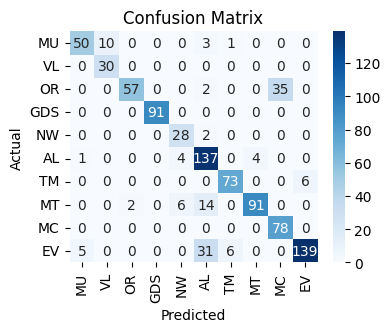

In [17]:
conf_matrix_svc = confusion_matrix(test_labels, predictions, labels=possible_classes)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_svc,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=possible_classes,
            yticklabels=possible_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Pipeline with wordtovector (SVC + W2V)

In [18]:

model = api.load('word2vec-google-news-300')

def sentence_to_vec(sentence, model):
    words = sentence.lower().split()
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Example
sentence_vec = sentence_to_vec("Example phrase", model)

class Word2VecVectorizer(TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sentence_to_vec(sentence, self.model) for sentence in X])

word2vec_svc_pipeline = make_pipeline(
    Word2VecVectorizer(model),
    SVC(kernel='linear', probability=True,C=1,degree=2,gamma='scale',shrinking=True)
)

word2vec_svc_pipeline.fit(train_data,train_labels)
score = word2vec_svc_pipeline.score(test_data, test_labels)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Evaluations results

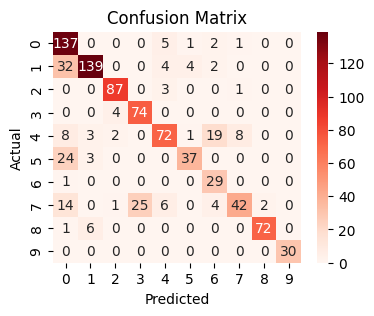

In [19]:

y_pred = word2vec_svc_pipeline.predict(test_data)
word2vec_report = classification_report(test_labels, y_pred)

conf_matrix_word2vec = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_word2vec, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Model Embending (Two model of svc with different parameters)

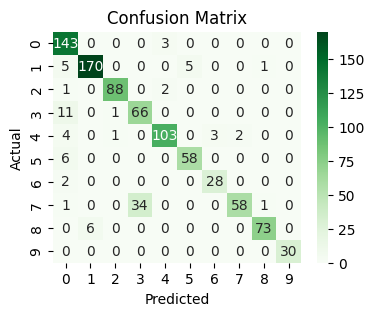

In [20]:

# Create the TF-IDF vectorizer.
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 1), norm='l1', use_idf=True)

# Define base patterns
base_learners = [
    ('svc_linear', SVC(kernel='linear', C=1, probability=True)),
    ('svc_rbf', SVC(kernel='rbf', C=1, gamma='auto', probability=True)),
]

# Define meta-learner
meta_learner = LogisticRegression()

# Create the ensemble model
ensemble_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Create the pipeline
model_embed = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('ensemble', ensemble_model)
])

# Train the pipeline on the training set.
model_embed.fit(train_data, train_labels)

# Evaluates the model on the test set
ensemble_score = model_embed.score(test_data, test_labels)

# Make predictions on the test set.
y_pred = model_embed.predict(test_data)

embed_report = classification_report(test_labels, y_pred)
# Calculate and display the confusion matrix
conf_matrix_ensemble = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()






Download the model choised

In [21]:
model_path = "model\model_it.pkl"
joblib.dump(model_embed, model_path)

['model\\model_it.pkl']

Manual test all model

In [22]:
sentence = "Ciao questa è una frase italiana"
filtered_tokens = []

tokens = word_tokenize(sentence)

# Similar (not the same although it changes little) sentence processing of the sentence
for word in tokens:
    word = word.lower()
    if word not in (",", "?"):
        filtered_tokens.append(word)
        
filtered_tokens = " ".join(filtered_tokens)

In [24]:
prhase_vectorize = tfidf_vectorizer.transform([filtered_tokens])

#SVC
result_svc = calibrated_model.predict(prhase_vectorize)

#WORD2VEC
result_word2vec = word2vec_svc_pipeline.predict([filtered_tokens])

#ESSEMBLE MODEL
result_essemble = model_embed.predict([filtered_tokens])

# Get the current date and time
current_datetime = datetime.now()
current_datetime_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

with open("result_it.txt","w")as file:
     file.write(f'''
                
{current_datetime_str}     

Frase originale: {sentence}    
Frase processata: {filtered_tokens}    
Risultato SVC: {result_svc}
Risultato Word2Vec: {result_word2vec}                
Risultato Ensemble model: {result_essemble}             

                                   ---------- REPORT ----------
 
  --- Report svc: ---                            
 
     {svc_report}                     
  
  --- Report Word2Vec: ---
  
     {word2vec_report}                     
  
  --- Report Embed ---  [BEST]                                                                                                                      
     {embed_report}                                                                                                                         
                ''')

print(f"Frase: {sentence}")
print(f"Frase processata: {filtered_tokens}")
print(f"Risultato SVC: {result_svc}")
print(f"Risultato Word2Vec: {result_word2vec}")
print(f"Risultato Ensemble model: {result_essemble}")



Frase: Ciao questa è una frase italiana
Frase processata: ciao questa è una frase italiana
Risultato SVC: ['MU']
Risultato Word2Vec: ['MT']
Risultato Ensemble model: ['MU']


Grid search time of esecution 16 minuts

In [ ]:
"""from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline with TF-IDF vectorizer and SVC model
model_embed = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [500, 1000, 2000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__degree': [2, 3, 4],  # Only used when kernel is 'poly'
    'clf__gamma': ['scale', 'auto'],
    'clf__shrinking': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model_embed, param_grid, cv=5, verbose=1, n_jobs=-1)

# Assume train_data and train_labels are your training data and labels
X_train, y_train = train_data, train_labels

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)
"""

"from sklearn.svm import SVC\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.model_selection import GridSearchCV\n\n# Create a pipeline with TF-IDF vectorizer and SVC model\nmodel_embed = Pipeline([\n    ('tfidf', TfidfVectorizer()),\n    ('clf', SVC())\n])\n\n# Define the parameter grid for GridSearchCV\nparam_grid = {\n    'tfidf__max_features': [500, 1000, 2000, None],\n    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],\n    'tfidf__use_idf': [True, False],\n    'tfidf__norm': ['l1', 'l2'],\n    'clf__C': [0.01, 0.1, 1, 10, 100],\n    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],\n    'clf__degree': [2, 3, 4],  # Only used when kernel is 'poly'\n    'clf__gamma': ['scale', 'auto'],\n    'clf__shrinking': [True, False]\n}\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(model_embed, param_grid, cv=5, verbose=1, n_jobs=-1)\n\n# Assume train_data and train_labels are your training data and labels\nX_train, y_train = train_data, train_labels\n\n# Fit the model\ngrid